In [33]:
import pandas as pd
import os
import spacy
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.utils import simple_preprocess

In [2]:
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf

/Users/matheus/miniconda3/envs/steam-analysis/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-02 20:48:25.777104: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


RuntimeError: Failed to import transformers.models.bert.modeling_tf_bert because of the following error (look up to see its traceback):
Your currently installed version of Keras is Keras 3, but this is not yet supported in Transformers. Please install the backwards-compatible tf-keras package with `pip install tf-keras`.

In [2]:
os.chdir("../..")

In [3]:
steam_df = pd.read_csv("data/raw/games.csv")

In [4]:
steam_df["total_reviews"] = steam_df["Positive"] + steam_df["Negative"]
steam_df["success"] = steam_df["total_reviews"] > 500

In [5]:
steam_success = steam_df[steam_df["success"] == 1]
steam_failure = steam_df[steam_df["success"] == 0]

In [6]:
steam_success_about = steam_success["About the game"]
steam_failure_about = steam_failure["About the game"]

In [7]:
steam_success_about.dropna(inplace=True)
steam_failure_about.dropna(inplace=True)

/var/folders/25/8m9ycrtx2kv84b8szslr4jfc0000gp/T/ipykernel_8025/3860958588.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  steam_success_about.dropna(inplace=True)
/var/folders/25/8m9ycrtx2kv84b8szslr4jfc0000gp/T/ipykernel_8025/3860958588.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  steam_failure_about.dropna(inplace=True)


In [10]:
# import spacy
# import pandas as pd
# from collections import Counter
# import matplotlib.pyplot as plt

# Load the spaCy language model
nlp = spacy.load("en_core_web_sm")

# Assuming you have a pandas Series with your texts
# For example:
# texts = pd.Series(["This is a sample sentence.", "Another text for processing."])
# Replace with your actual series
# texts = steam_about


# Function to count POS tags in a single text
def count_pos(text):
    doc = nlp(text)
    return [token.pos_ for token in doc]

In [11]:
# Apply the function to each text and aggregate the results
pos_counts = Counter()
for text in steam_failure_about[:1000]:
    pos_counts.update(count_pos(text))

# Convert the counter to a DataFrame for easier plotting
# pos_df = pd.DataFrame.from_dict(pos_counts, orient='index', columns=['count'])

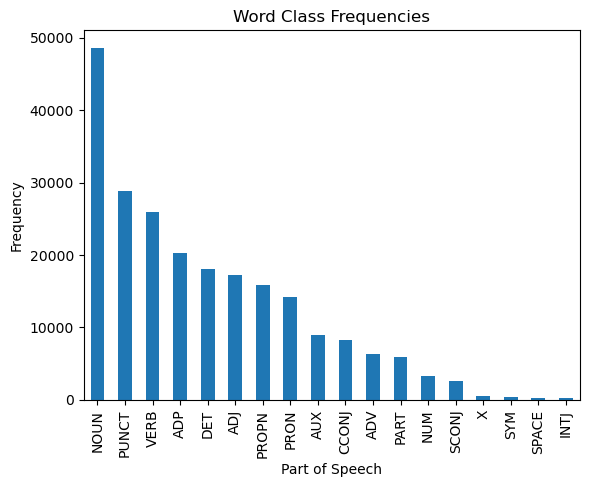

In [12]:
# Plot the histogram
pos_df = pd.DataFrame.from_dict(pos_counts, orient="index", columns=["count"])

pos_df.sort_values("count", ascending=False).plot(kind="bar", legend=False)
plt.xlabel("Part of Speech")
plt.ylabel("Frequency")
plt.title("Word Class Frequencies")
plt.show()

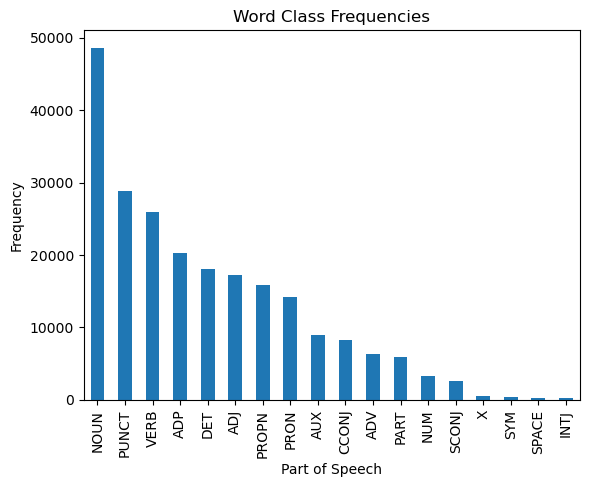

In [13]:
# Plot the histogram
pos_df = pd.DataFrame.from_dict(pos_counts, orient="index", columns=["count"])

pos_df.sort_values("count", ascending=False).plot(kind="bar", legend=False)
plt.xlabel("Part of Speech")
plt.ylabel("Frequency")
plt.title("Word Class Frequencies")
plt.show()

In [17]:
import spacy
import pandas as pd
from collections import Counter
import numpy as np

# Load the spaCy language model
nlp = spacy.load("en_core_web_sm")


def count_pos(text):
    """Count the POS tags in a single text"""
    doc = nlp(text)
    return [token.pos_ for token in doc]


def get_pos_counts(texts):
    """Get POS counts for a dataset"""
    pos_counts = []
    for text in texts:
        if isinstance(text, str):  # Ensure text is a string
            pos_counts.append(count_pos(text))
    return pos_counts


def calculate_pos_stats(texts):
    """
    Calculate the mean and standard deviation of POS counts for a list of texts.

    Parameters:
    texts (list of str): List of text documents.

    Returns:
    pd.DataFrame: DataFrame with mean and standard deviation for each POS.
    """
    pos_counts = get_pos_counts(texts)

    # Flatten the list of POS counts and create a Counter for each document
    pos_counters = [Counter(pos_list) for pos_list in pos_counts]

    # Create a DataFrame from the list of Counters
    pos_df = pd.DataFrame(pos_counters).fillna(0).astype(int)

    # Calculate mean and standard deviation for each POS
    pos_mean = pos_df.mean()
    pos_std = pos_df.std()

    # Combine the results into a single DataFrame
    pos_stats = pd.DataFrame({"mean": pos_mean, "std": pos_std})

    return pos_stats

In [18]:
pos_stats = calculate_pos_stats(steam_failure_about[:1000])
print(pos_stats)

         mean        std
PROPN  15.843  20.597976
AUX     8.873  10.112821
DET    18.106  17.396995
ADJ    17.178  15.471771
CCONJ   8.287   8.085172
NOUN   48.626  44.663037
ADP    20.260  17.749914
PUNCT  28.865  27.885630
VERB   25.925  22.804197
ADV     6.265   7.268673
SCONJ   2.603   3.338643
PRON   14.234  14.864663
PART    5.852   6.778203
NUM     3.276   4.709778
X       0.571   2.559592
INTJ    0.196   0.661832
SYM     0.435   2.251854
SPACE   0.206   3.625563


In [19]:
pos_stats = calculate_pos_stats(steam_success_about[:1000])
print(pos_stats)

         mean        std
VERB   35.969  26.611392
PRON   18.586  16.060590
ADP    30.981  21.953464
NOUN   70.855  51.547426
PART    7.444   6.381974
DET    25.063  19.570233
ADJ    26.900  19.680888
CCONJ  13.750  11.159123
PROPN  25.294  25.472700
NUM     4.058   4.781370
PUNCT  40.295  30.204176
AUX    10.473  10.106206
SCONJ   3.177   3.367642
ADV     9.130   8.583051
X       0.329   1.305551
SPACE   0.183   3.236663
SYM     0.378   1.868317
INTJ    0.189   0.706950


In [22]:
import spacy
import pandas as pd
from collections import Counter
import numpy as np

# Load the spaCy language model
nlp = spacy.load("en_core_web_sm")


def count_pos(text):
    """Count the POS tags in a single text"""
    doc = nlp(text)
    return [token.pos_ for token in doc]


def get_pos_counts(texts):
    """Get POS counts for a dataset"""
    pos_counts = []
    for text in texts:
        if isinstance(text, str):  # Ensure text is a string
            pos_counts.append(count_pos(text))
    return pos_counts


def calculate_pos_stats(texts):
    """
    Calculate the mean and standard deviation of POS counts for a list of texts.

    Parameters:
    texts (list of str): List of text documents.

    Returns:
    pd.DataFrame: DataFrame with mean and standard deviation for each POS.
    """
    pos_counts = get_pos_counts(texts)

    # Flatten the list of POS counts and create a Counter for each document
    pos_counters = [Counter(pos_list) for pos_list in pos_counts]

    # Create a DataFrame from the list of Counters
    pos_df = pd.DataFrame(pos_counters).fillna(0).astype(int)

    # Calculate mean and standard deviation for each POS
    pos_mean = pos_df.mean()
    pos_std = pos_df.std()

    # Combine the results into a single DataFrame
    pos_stats = pd.DataFrame({"mean": pos_mean, "std": pos_std})

    return pos_stats

In [28]:
pos_stats_success = calculate_pos_stats(steam_success_about[:1000])
print(pos_stats_success)

         mean        std
VERB   35.969  26.611392
PRON   18.586  16.060590
ADP    30.981  21.953464
NOUN   70.855  51.547426
PART    7.444   6.381974
DET    25.063  19.570233
ADJ    26.900  19.680888
CCONJ  13.750  11.159123
PROPN  25.294  25.472700
NUM     4.058   4.781370
PUNCT  40.295  30.204176
AUX    10.473  10.106206
SCONJ   3.177   3.367642
ADV     9.130   8.583051
X       0.329   1.305551
SPACE   0.183   3.236663
SYM     0.378   1.868317
INTJ    0.189   0.706950


In [29]:
pos_stats_failure = calculate_pos_stats(steam_failure_about[:1000])
print(pos_stats_failure)

         mean        std
PROPN  15.843  20.597976
AUX     8.873  10.112821
DET    18.106  17.396995
ADJ    17.178  15.471771
CCONJ   8.287   8.085172
NOUN   48.626  44.663037
ADP    20.260  17.749914
PUNCT  28.865  27.885630
VERB   25.925  22.804197
ADV     6.265   7.268673
SCONJ   2.603   3.338643
PRON   14.234  14.864663
PART    5.852   6.778203
NUM     3.276   4.709778
X       0.571   2.559592
INTJ    0.196   0.661832
SYM     0.435   2.251854
SPACE   0.206   3.625563


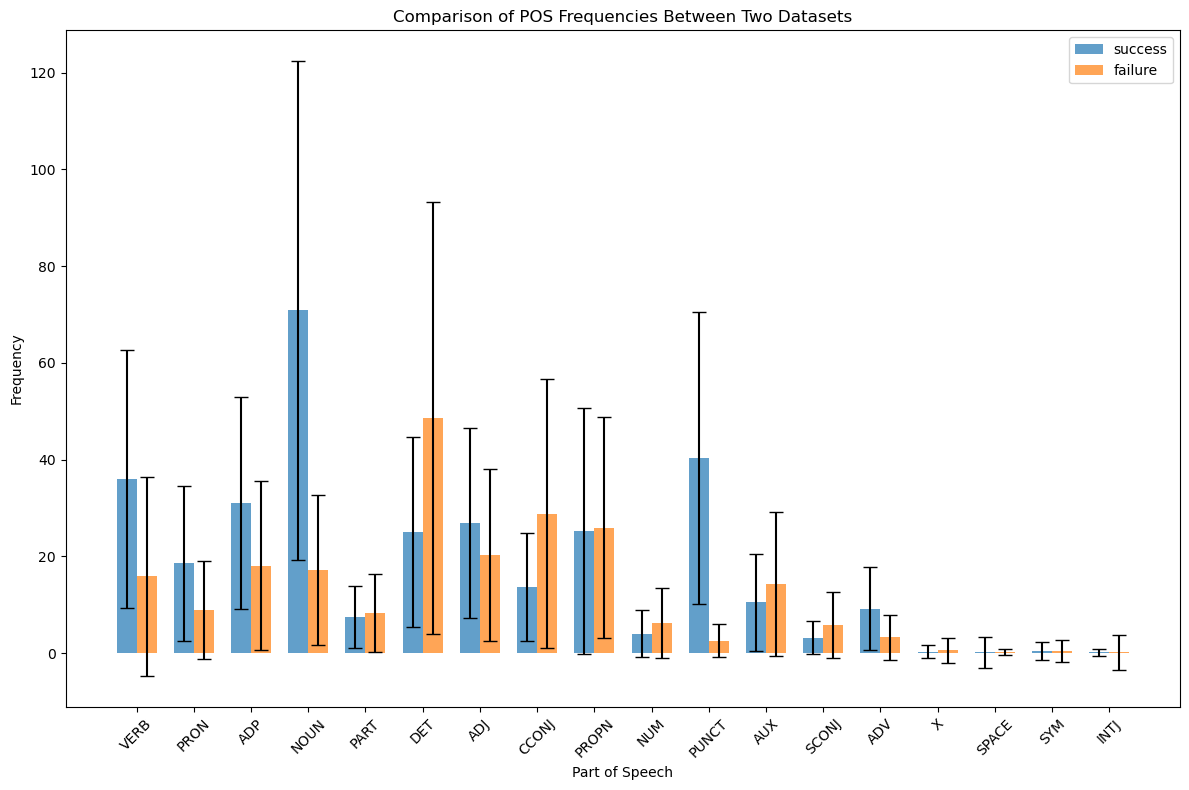

In [30]:
# Sample DataFrames for demonstration (replace with your actual DataFrames)
# pos_stats_df1 = ...
# pos_stats_df2 = ...

# Extract POS tags, means, and standard deviations
pos_tags = pos_stats.index
means1 = pos_stats_success["mean"]
stds1 = pos_stats_success["std"]
means2 = pos_stats_failure["mean"]
stds2 = pos_stats_failure["std"]

# Set up the bar width and positions
bar_width = 0.35
index = np.arange(len(pos_tags))

# Create a bar plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot dataset 1
bar1 = ax.bar(
    index, means1, bar_width, yerr=stds1, label="success", alpha=0.7, capsize=5
)

# Plot dataset 2
bar2 = ax.bar(
    index + bar_width,
    means2,
    bar_width,
    yerr=stds2,
    label="failure",
    alpha=0.7,
    capsize=5,
)

# Add labels, title, and legend
ax.set_xlabel("Part of Speech")
ax.set_ylabel("Frequency")
ax.set_title("Comparison of POS Frequencies Between Two Datasets")
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(pos_tags, rotation=45)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [47]:
# Load the spaCy model
nlp = spacy.load("en_core_web_lg")

# Example pandas Series of texts
texts = steam_failure_about[:1000]

# Initialize lists to store aggregated metrics
all_token_counts = []
all_token_lengths = []
all_clause_counts = []
all_ttrs = []
all_flesch_reading_eases = []
all_gunning_fogs = []

# Process each text in the Series
for text in texts:
    doc = nlp(text)

    # Initialize lists to store metrics for the current text
    token_counts = []
    token_lengths = []
    clause_counts = []
    ttrs = []
    flesch_reading_eases = []
    gunning_fogs = []

    # Calculate complexity metrics for each sentence in the current text
    for sentence in doc.sents:
        words = [token.text for token in sentence if token.is_alpha]
        unique_words = set(words)
        ttr = len(unique_words) / len(words) if words else 0

        token_counts.append(len(sentence))
        token_lengths.append(np.mean([len(token) for token in sentence]))
        clause_counts.append(
            len(
                [
                    token
                    for token in sentence
                    if token.dep_ == "ccomp" or token.dep_ == "advcl"
                ]
            )
        )
        ttrs.append(ttr)
        flesch_reading_eases.append(textstat.flesch_reading_ease(sentence.text))
        gunning_fogs.append(textstat.gunning_fog(sentence.text))

    # Append the mean metrics of the current text to the aggregated lists
    all_token_counts.append(np.mean(token_counts))
    all_token_lengths.append(np.mean(token_lengths))
    all_clause_counts.append(np.mean(clause_counts))
    all_ttrs.append(np.mean(ttrs))
    all_flesch_reading_eases.append(np.mean(flesch_reading_eases))
    all_gunning_fogs.append(np.mean(gunning_fogs))

# Calculate overall means and standard deviations for all texts
mean_token_count = np.mean(all_token_counts)
std_token_count = np.std(all_token_counts)

mean_token_length = np.mean(all_token_lengths)
std_token_length = np.std(all_token_lengths)

mean_clause_count = np.mean(all_clause_counts)
std_clause_count = np.std(all_clause_counts)

mean_ttr = np.mean(all_ttrs)
std_ttr = np.std(all_ttrs)

mean_flesch_reading_ease = np.mean(all_flesch_reading_eases)
std_flesch_reading_ease = np.std(all_flesch_reading_eases)

mean_gunning_fog = np.mean(all_gunning_fogs)
std_gunning_fog = np.std(all_gunning_fogs)

# Print the summarized metrics
print(
    f"Mean number of tokens per sentence: {mean_token_count:.2f} (std: {std_token_count:.2f})"
)
print(f"Mean token length: {mean_token_length:.2f} (std: {std_token_length:.2f})")
print(
    f"Mean number of subordinate clauses per sentence: {mean_clause_count:.2f} (std: {std_clause_count:.2f})"
)
print(f"Mean Type-Token Ratio (TTR): {mean_ttr:.2f} (std: {std_ttr:.2f})")
print(
    f"Mean Flesch Reading Ease: {mean_flesch_reading_ease:.2f} (std: {std_flesch_reading_ease:.2f})"
)
print(f"Mean Gunning Fog Index: {mean_gunning_fog:.2f} (std: {std_gunning_fog:.2f})")

Mean number of tokens per sentence: 19.41 (std: 8.77)
Mean token length: 4.49 (std: 2.41)
Mean number of subordinate clauses per sentence: 0.49 (std: 0.42)
Mean Type-Token Ratio (TTR): 0.93 (std: 0.07)
Mean Flesch Reading Ease: 65.75 (std: 15.18)
Mean Gunning Fog Index: 10.08 (std: 3.62)


In [12]:
nlp = spacy.load("en_core_web_lg")

In [48]:
import spacy
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load spaCy model with vectors
nlp = spacy.load("en_core_web_lg")


def extract_adjectives(text):
    doc = nlp(text)
    adjectives = [token.lemma_ for token in doc if token.pos_ == "ADJ"]
    return adjectives


def get_adjective_vectors(adjectives):
    vectors = [nlp(word).vector for word in adjectives if word in nlp.vocab]
    return vectors


def calculate_similarity(user_vectors, model_vectors):
    if not user_vectors or not model_vectors:
        return 0.0

    # Average vectors for each text
    user_vector_avg = np.mean(user_vectors, axis=0)
    model_vector_avg = np.mean(model_vectors, axis=0)

    # Calculate cosine similarity
    similarity = cosine_similarity([user_vector_avg], [model_vector_avg])[0][0]
    return similarity

In [54]:
# Example texts
user_text = steam_failure_about.iloc[60]
model_text = steam_success_about.iloc[1]

# Process texts
user_adjectives = extract_adjectives(user_text)
model_adjectives = extract_adjectives(model_text)

user_vectors = get_adjective_vectors(user_adjectives)
model_vectors = get_adjective_vectors(model_adjectives)

similarity_score = calculate_similarity(user_vectors, model_vectors)
print("Adjective Similarity Score:", similarity_score)

Adjective Similarity Score: 0.72757053


In [10]:
# Define a function to extract adjectives from a single text
def extract_adjectives(text):
    if pd.isna(text):
        return []
    doc = nlp(text)
    adjectives = [token.lemma_ for token in doc if token.pos_ == "ADJ"]
    return adjectives

In [ ]:
adjectives_count = [token.lemma_ for token in doc if token.pos_ == "ADJ"]

In [13]:
# Example pd.Series of texts
texts = steam_success_about[:1000]

# Apply the function to the entire pd.Series to get adjectives for each text
all_adjectives = texts.apply(extract_adjectives)

# Flatten the list of lists into a single list
flat_adjectives = [adj for sublist in all_adjectives for adj in sublist]

# Count the occurrences of each adjective
adjective_counts = Counter(flat_adjectives)

# Convert the counter to a DataFrame for better visualization
adjective_df_success = pd.DataFrame(
    adjective_counts.items(), columns=["Adjective", "Count"]
)

print(adjective_df_success)

        Adjective  Count
0      accidental      3
1      tremendous      7
2        tactical    120
3             rpg     47
4           young     74
...           ...    ...
2837      suspect      1
2838  overwrought      1
2839     synthpop      1
2840    pseudo-3d      1
2841  immersively      1

[2842 rows x 2 columns]


In [14]:
# Example pd.Series of texts
texts = steam_failure_about[:1000]

# Apply the function to the entire pd.Series to get adjectives for each text
all_adjectives = texts.apply(extract_adjectives)

# Flatten the list of lists into a single list
flat_adjectives = [adj for sublist in all_adjectives for adj in sublist]

# Count the occurrences of each adjective
adjective_counts = Counter(flat_adjectives)

# Convert the counter to a DataFrame for better visualization
adjective_df_failure = pd.DataFrame(
    adjective_counts.items(), columns=["Adjective", "Count"]
)

print(adjective_df_failure)

          Adjective  Count
0       exaggerated      1
1          stylized      4
2     intergalactic      3
3            single     89
4             multi     10
...             ...    ...
2327     contestant      1
2328        ragdoll      1
2329       nameless      1
2330        amnesic      1
2331        dreaded      1

[2332 rows x 2 columns]


In [68]:
set(adjective_df_success.nlargest(100, "Count")["Adjective"]) - set(
    adjective_df_failure.nlargest(100, "Count")["Adjective"]
)

{'additional',
 'advanced',
 'deadly',
 'deep',
 'detailed',
 'entire',
 'favorite',
 'intense',
 'late',
 'legendary',
 'massive',
 'personal',
 'realistic',
 'rich',
 'strategic',
 'stunning',
 'ultimate',
 'vast',
 'wide'}

In [69]:
set(adjective_df_failure.nlargest(100, "Count")["Adjective"]) - set(
    adjective_df_success.nlargest(100, "Count")["Adjective"]
)

{'2d',
 'alive',
 'bad',
 'certain',
 'colorful',
 'current',
 'difficult',
 'evil',
 'final',
 'hard',
 'important',
 'interactive',
 'interesting',
 'like',
 'magical',
 'most',
 'short',
 'specific',
 'top'}

In [82]:
filtered_df = adjective_df.nlargest(45, "Count")
filtered_failure_df = adjective_df_failure.nlargest(45, "Count")

training word2vec

In [35]:
pre_processed_reviews = steam_df["About the game"].dropna().apply(simple_preprocess)
model = Word2Vec(
    pre_processed_reviews, vector_size=100, window=5, min_count=1, workers=4
)

In [48]:
model.wv.similarity(w1="brazil", w2="argentina")

0.8217431

In [70]:
words_success = {
    "additional",
    "advanced",
    "deadly",
    "deep",
    "detailed",
    "entire",
    "favorite",
    "intense",
    "late",
    "legendary",
    "massive",
    "personal",
    "realistic",
    "rich",
    "strategic",
    "stunning",
    "ultimate",
    "vast",
    "wide",
}

In [75]:
words_failure = {
    "2d",
    "alive",
    "bad",
    "certain",
    "colorful",
    "current",
    "difficult",
    "evil",
    "final",
    "hard",
    "important",
    "interactive",
    "interesting",
    "like",
    "magical",
    "most",
    "short",
    "specific",
    "top",
}

In [72]:
# Get the vectors for the words in the list and compute the mean vector
vectors_success = [model.wv[word] for word in words_success if word in model.wv]
mean_vector_success = np.mean(vectors_success, axis=0)

In [76]:
# Get the vectors for the words in the list and compute the mean vector
vectors_failure = [model.wv[word] for word in words_failure if word in model.wv]
mean_vector_failure = np.mean(vectors_failure, axis=0)

In [77]:
cosine_similarity(
    mean_vector_success.reshape(1, -1), mean_vector_failure.reshape(1, -1)
)[0][0]

0.53824407